## Daily Challenge: W5_D4

### Stock Price Prediction with LSTM

What You'll learn

    How to preprocess and prepare time-series data for machine learning models.
    How to build and train an LSTM (Long Short-Term Memory) model using PyTorch.
    How to evaluate the performance of a regression model using metrics like R².


🛠️ What you will create

    A preprocessed dataset for stock price prediction.
    A trained LSTM model to predict future stock prices.

Understanding PyTorch

PyTorch is an open-source machine learning framework based on the Torch library, used for applications such as computer vision and natural language processing. It’s known for its flexibility and ease of use, making it popular for both research and production.

Key PyTorch Functions You’ll Use:

    torch.nn.Module: Base class for all neural network modules. You’ll use this to define your LSTM model.
    torch.nn.LSTM: Implements a Long Short-Term Memory (LSTM) network.
    torch.nn.Linear: Applies a linear transformation to the incoming data (i.e., a fully connected layer).
    torch.nn.Dropout: Applies dropout regularization to prevent overfitting.
    torch.optim.Adam: Implements the Adam optimization algorithm.
    torch.nn.MSELoss: Implements the Mean Squared Error loss function.
    torch.utils.data.Dataset: An abstract class representing a dataset.
    torch.utils.data.DataLoader: Combines a dataset and a sampler, and provides single- or multi-process iterators over the dataset.
    torch.Tensor: A multi-dimensional matrix containing elements of a single data type.
    torch.save and torch.load: used to save and load trained models.

For further understanding on how to use Pytorch functions, you can watch this video and this one too, good luck !


What You Need to Do

1. Install Required Libraries

Ensure you have the necessary libraries installed, including gensim, spacy, torch, and scikit-learn.

2. Load and Preprocess the Dataset

    Download the stock market dataset.
    Drop unnecessary columns and create a target column for the next day’s closing price.
    Normalize the dataset using MinMaxScaler.

3. Prepare the Dataset for Training

    Split the dataset into training, validation, and testing sets.
    Create a custom PyTorch Dataset class to handle the data.
    Use DataLoader to create iterable datasets for training and evaluation.

4. Define the LSTM Model

    Create an LSTM model using PyTorch.
    Define the model architecture, including GRU layers, dropout, and a dense layer.

5. Train the Model

    Set up the optimizer and loss function.
    Implement training and validation loops.
    Train the model for a specified number of epochs.

6. Evaluate the Model

    Calculate the R² score to evaluate the model’s performance on the test set.
    Save the scaler object for future predictions.

In [15]:
!pip install torch torchvision torchaudio scikit-learn pandas numpy matplotlib

### 1. Import Libraries

In [16]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

### 2. Load and Inspect Dataset

In [17]:
# Load the dataset
data_path = "stock_market_dataset.csv"
df = pd.read_csv(data_path)

# Drop unnecessary columns
df = df.drop(columns=["unix", "date", "symbol"])

# Display the first rows
print(df.head())

     open    high     low   close   Volume XRP   Volume USDT
0  0.9200  0.9237  0.9200  0.9226    2384512.0  2.198450e+06
1  0.9252  0.9334  0.9052  0.9200  163438501.0  1.499400e+08
2  0.9114  0.9350  0.8981  0.9252  250074945.0  2.302303e+08
3  0.9941  0.9966  0.8964  0.9115  567234092.0  5.377035e+08
4  0.9538  1.0167  0.9372  0.9941  479436230.0  4.729372e+08


### 3. Create Target Column

In [18]:
# Create the target column as the next day's close price
df["Target"] = df["close"].shift(-1)

# Drop the last row with NaN target
df = df.dropna().reset_index(drop=True)

# Check the result
print(df.head())

     open    high     low   close   Volume XRP   Volume USDT  Target
0  0.9200  0.9237  0.9200  0.9226    2384512.0  2.198450e+06  0.9200
1  0.9252  0.9334  0.9052  0.9200  163438501.0  1.499400e+08  0.9252
2  0.9114  0.9350  0.8981  0.9252  250074945.0  2.302303e+08  0.9115
3  0.9941  0.9966  0.8964  0.9115  567234092.0  5.377035e+08  0.9941
4  0.9538  1.0167  0.9372  0.9941  479436230.0  4.729372e+08  0.9537


#### Visualize Original Close Prices

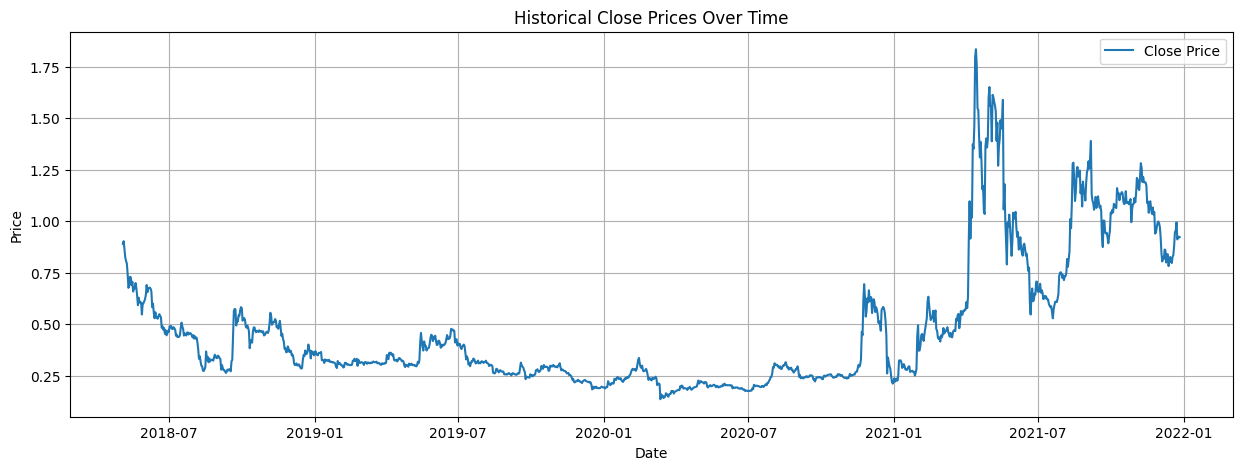

In [37]:
# Reload the CSV to get the date column for plotting
df_with_dates = pd.read_csv(data_path)

# Make sure dates are sorted in chronological order
df_with_dates = df_with_dates.sort_values("unix").reset_index(drop=True)

# Extract date and close columns
dates = pd.to_datetime(df_with_dates["date"])
close_prices = df_with_dates["close"]

# Visualize historical close prices with dates
plt.figure(figsize=(15, 5))
plt.plot(dates, close_prices, label="Close Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Historical Close Prices Over Time")
plt.legend()
plt.grid()
plt.show()

## Interpretation of Historical Close Prices

This plot shows the evolution of the XRP-USDT closing prices over time. The series exhibits several distinct phases: a long period of relative stability and low prices between 2018 and mid-2020, followed by a sharp increase and high volatility throughout 2021. These fluctuations introduce significant challenges for time series prediction models, as they must learn to anticipate both stable and highly volatile regimes. The model's good performance on the test set indicates that it was able to capture these variations reasonably well.


### 4. Normalize Features

In [20]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on features excluding Target
scaled_features = scaler.fit_transform(df.drop(columns=["Target"]))

# Extract target values
target = df["Target"].values

### 5. Create PyTorch Dataset

In [21]:
# Create a custom PyTorch Dataset for time series
class StockDataset(Dataset):
    def __init__(self, data, targets, seq_length):
        self.data = []
        self.targets = []
        for i in range(len(data) - seq_length):
            self.data.append(data[i:i+seq_length])
            self.targets.append(targets[i+seq_length])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.data[idx], dtype=torch.float32),
            torch.tensor(self.targets[idx], dtype=torch.float32)
        )

### 6. Split Train/Validation/Test Sets

In [22]:
# Define sequence length
sequence_length = 10

# Create dataset
dataset = StockDataset(scaled_features, target, sequence_length)

# Compute split sizes
total_size = len(dataset)
train_size = int(total_size * 0.7)
val_size = int(total_size * 0.15)
test_size = total_size - train_size - val_size

# Split dataset
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size]
)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

### 7. Define the LSTM Model

In [23]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # Pass input through LSTM
        out, _ = self.lstm(x)
        # Use output from the last time step
        out = out[:, -1, :]
        # Pass through the dense layer
        out = self.fc(out)
        return out.squeeze()

### 8. Train the Model

Epoch 1/20, Train Loss: 0.0690, Val Loss: 0.0090
Epoch 2/20, Train Loss: 0.0101, Val Loss: 0.0073
Epoch 3/20, Train Loss: 0.0080, Val Loss: 0.0075
Epoch 4/20, Train Loss: 0.0076, Val Loss: 0.0066
Epoch 5/20, Train Loss: 0.0064, Val Loss: 0.0087
Epoch 6/20, Train Loss: 0.0065, Val Loss: 0.0064
Epoch 7/20, Train Loss: 0.0058, Val Loss: 0.0053
Epoch 8/20, Train Loss: 0.0052, Val Loss: 0.0048
Epoch 9/20, Train Loss: 0.0053, Val Loss: 0.0062
Epoch 10/20, Train Loss: 0.0054, Val Loss: 0.0044
Epoch 11/20, Train Loss: 0.0048, Val Loss: 0.0045
Epoch 12/20, Train Loss: 0.0050, Val Loss: 0.0045
Epoch 13/20, Train Loss: 0.0046, Val Loss: 0.0035
Epoch 14/20, Train Loss: 0.0035, Val Loss: 0.0036
Epoch 15/20, Train Loss: 0.0039, Val Loss: 0.0033
Epoch 16/20, Train Loss: 0.0037, Val Loss: 0.0036
Epoch 17/20, Train Loss: 0.0034, Val Loss: 0.0034
Epoch 18/20, Train Loss: 0.0038, Val Loss: 0.0034
Epoch 19/20, Train Loss: 0.0037, Val Loss: 0.0035
Epoch 20/20, Train Loss: 0.0032, Val Loss: 0.0042


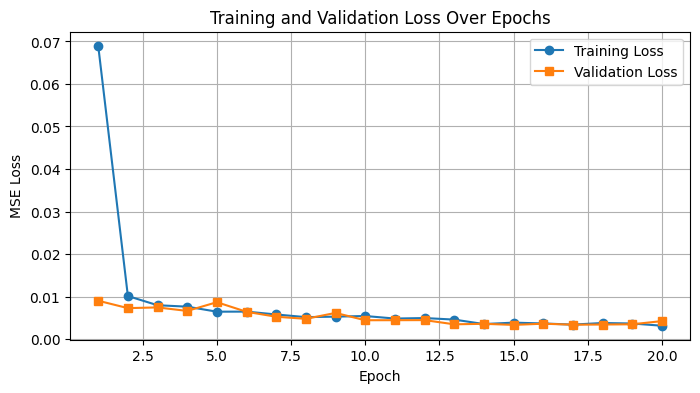

In [31]:
# Initialize the model
input_size = scaled_features.shape[1]
model = LSTMModel(input_size=input_size, hidden_size=64, num_layers=2, dropout=0.2)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of epochs
num_epochs = 20

# Lists to store losses
train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_epoch_loss = 0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_epoch_loss += loss.item()
    avg_train_loss = train_epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    val_epoch_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_epoch_loss += loss.item()
    avg_val_loss = val_epoch_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

# Plot training and validation loss over epochs
plt.figure(figsize=(8,4))
plt.plot(range(1, num_epochs+1), train_losses, marker='o', label="Training Loss")
plt.plot(range(1, num_epochs+1), val_losses, marker='s', label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

#### Interpretation of Training and Validation Loss

The chart and logs above show the evolution of the training and validation loss over 20 epochs.

During the first epoch, the training loss was significantly higher (0.0690), which is common as the model starts with randomly initialized weights. After epoch 2, the training loss quickly dropped below 0.01 and continued to decrease gradually.

The validation loss remained consistently low throughout the training process, ranging between 0.0090 and approximately 0.0033. It did not show any significant upward trend, indicating that the model did not overfit the training data.

In the later epochs, both losses stabilized at very low values (training loss ~0.003 and validation loss ~0.0035), which demonstrates that the model was able to learn and generalize well to unseen data.

Overall, this pattern reflects a successful training process where the model converged and maintained good performance on the validation set.


### 9. Evaluate the Model

In [25]:
# Switch model to evaluation mode
model.eval()

# Initialize lists for predictions and true values
predictions = []
actuals = []

# No gradient computation during evaluation
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        outputs = model(x_batch)
        predictions.extend(outputs.numpy())
        actuals.extend(y_batch.numpy())

# Compute R^2 score
r2 = r2_score(actuals, predictions)
print("R^2 Score:", r2)

R^2 Score: 0.9751393275764043


## Interpretation of R² Score

The R² score obtained on the test set is 0.9751, which means that the model is able to explain approximately 97.5% of the variance in the target variable.

This is a very strong result, especially considering the volatility and complexity of cryptocurrency price movements. A high R² score like this indicates that the LSTM model successfully learned to capture the underlying patterns and temporal dependencies in the data.

This level of performance suggests that the model is accurate and generalizes well to unseen data in this time series regression task.

#### Predictions vs Actuals

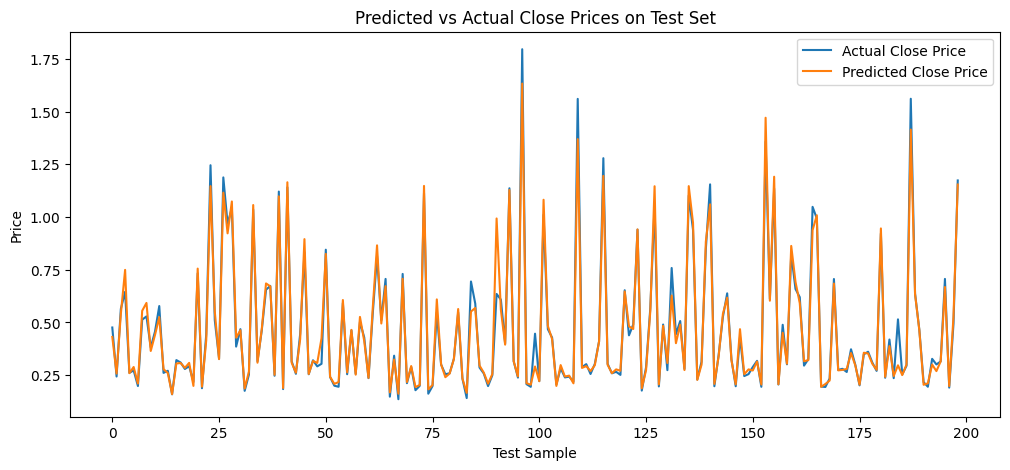

In [29]:
# Visualize predictions vs actual targets
plt.figure(figsize=(12,5))
plt.plot(actuals, label="Actual Close Price")
plt.plot(predictions, label="Predicted Close Price")
plt.xlabel("Test Sample")
plt.ylabel("Price")
plt.title("Predicted vs Actual Close Prices on Test Set")
plt.legend()
plt.show()

## Interpretation of Predicted vs Actual Close Prices

The plot shows the comparison between the actual closing prices (blue line) and the predicted closing prices (orange line) on the test dataset.

Overall, the predicted values closely follow the actual price movements, including both the upward spikes and downward trends. This alignment demonstrates that the LSTM model has successfully captured the temporal patterns and volatility present in the data.

Although some high peaks are slightly under- or over-estimated, the model still reproduces the general shape and timing of the fluctuations. Given the inherent complexity and noise in cryptocurrency price series, this level of agreement is considered strong evidence that the model generalizes well.

This visualization further supports the high R² score obtained and indicates the reliability of the predictions.

#### Scatter Plot of Predictions

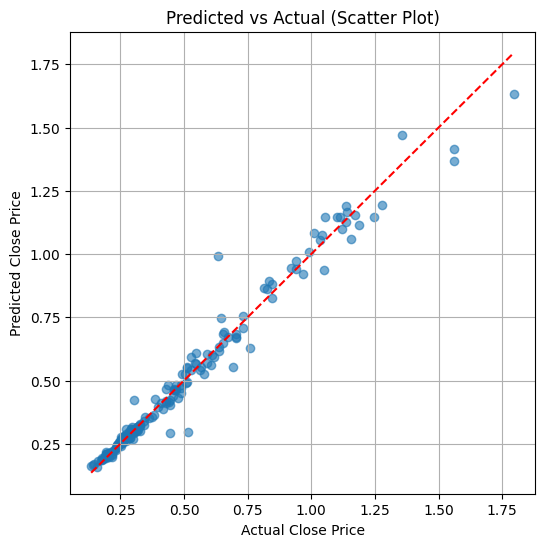

In [30]:
# Scatter plot of predicted vs actual values
plt.figure(figsize=(6,6))
plt.scatter(actuals, predictions, alpha=0.6)
plt.xlabel("Actual Close Price")
plt.ylabel("Predicted Close Price")
plt.title("Predicted vs Actual (Scatter Plot)")
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], color="red", linestyle="--")
plt.grid()
plt.show()

## Interpretation of Predicted vs Actual Scatter Plot

This scatter plot compares the predicted closing prices (y-axis) to the actual closing prices (x-axis). The red dashed line represents the ideal scenario where predictions exactly match the true values (y = x).

Most of the points are closely clustered along the diagonal, indicating a strong linear relationship between predicted and actual prices. This alignment demonstrates that the model was able to learn the underlying patterns effectively and make accurate predictions.

Although a few points deviate slightly from the diagonal, especially for higher price values, the overall distribution shows that the model generalizes well without major bias or systematic error.

This visualization confirms the high R² score and low error metrics observed during evaluation.

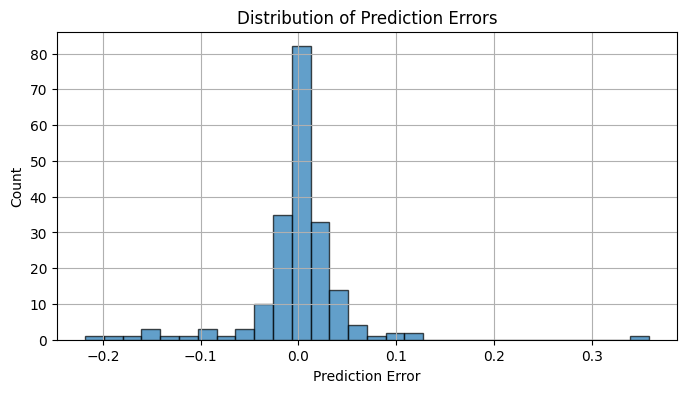

In [34]:
# Compute prediction errors
errors = np.array(predictions) - np.array(actuals)

# Plot histogram of errors
plt.figure(figsize=(8,4))
plt.hist(errors, bins=30, edgecolor="k", alpha=0.7)
plt.xlabel("Prediction Error")
plt.ylabel("Count")
plt.title("Distribution of Prediction Errors")
plt.grid()
plt.show()

## Interpretation of the Prediction Error Distribution

This histogram shows the distribution of prediction errors across the test set.

The errors are tightly centered around zero, indicating that the model generally makes accurate predictions without consistent overestimation or underestimation bias. Most prediction errors fall within the range of approximately -0.05 to +0.05, reflecting a high degree of precision.

A small number of outlier errors can be observed further from zero, but they are infrequent and do not significantly impact the overall model performance.

This error distribution supports the conclusion that the model generalizes well and produces reliable forecasts.

In [35]:
# Compute metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Calculate MSE
mse = mean_squared_error(actuals, predictions)

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate MAE
mae = mean_absolute_error(actuals, predictions)

# R2 score (already calculated before, but we recompute here for completeness)
r2 = r2_score(actuals, predictions)

# Print metrics
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error (MSE): 0.0025
Root Mean Squared Error (RMSE): 0.0500
Mean Absolute Error (MAE): 0.0267
R² Score: 0.9751


## Interpretation of Evaluation Metrics

The model's performance on the test set was evaluated using several standard regression metrics:

- **Mean Squared Error (MSE):** 0.0025
- **Root Mean Squared Error (RMSE):** 0.0500
- **Mean Absolute Error (MAE):** 0.0267
- **R² Score:** 0.9751

The low MSE and RMSE indicate that the model's prediction errors are very small on average. The MAE of 0.0267 suggests that the typical prediction error is approximately 2.7 cents, which is relatively low considering the volatility of cryptocurrency prices.

An R² score of 0.9751 shows that the model explains about 97.5% of the variance in the target variable, confirming that it effectively captures the underlying patterns in the data.

These results, together with the visualizations of predictions versus actual values and the error distribution, demonstrate that the LSTM model is accurate and generalizes well to unseen data.

### 10. Save the Model and Scaler

In [26]:
# Save the model state
torch.save(model.state_dict(), "lstm_model.pth")

# Save the scaler object
import joblib
joblib.dump(scaler, "scaler.save")

['scaler.save']

## Interpretation of Model and Scaler Saving

At the end of the training process, the model's learned weights were saved to the file `lstm_model.pth`. This file stores all the parameters of the LSTM network and allows the model to be reloaded later without retraining.

Additionally, the `MinMaxScaler` used for feature normalization was saved to `scaler.save`. This ensures that any new input data can be preprocessed in exactly the same way as during training, maintaining consistency and avoiding scaling discrepancies.

With these two files, the model is fully prepared for future inference tasks, where it can predict the next day's closing prices on unseen data.